In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns

In [3]:
table = pd.read_csv("F:\\Studium\\Master\\semester5\\thesis\\data\\NCBI\\100\\index\\kmer_distribution.tsv", sep="\t")
table

,range start,range end,total,species,genus,no rank,superkingdom,strain,family,phylum,...,subphylum,serotype,subtribe,section,superclass,serogroup,subcohort,biotype,subsection,series
0,0,4177248169415649,5598478,4365820,231275,312795,167051,86148,71898,66924,...,709,314,230,223,223,41,29,6,8,0
1,4177248169415650,8354496338831299,3336228,2614626,146512,159845,108363,44300,46141,46922,...,402,128,112,92,109,25,13,2,3,2
2,8354496338831300,12531744508246949,1076325,874503,47960,34407,21596,15108,15116,13699,...,130,42,41,28,36,9,3,3,1,1
3,12531744508246950,16708992677662599,980420,800601,42330,31603,17753,14954,12869,11590,...,110,50,31,35,30,9,6,1,0,0
4,16708992677662600,20886240847078249,579777,474956,25975,16059,10109,8051,8648,7493,...,70,32,20,24,15,7,0,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019,4256615884634547350,4260793132803962999,1498,1228,77,43,17,20,18,16,...,0,0,0,0,0,0,0,0,0,0
1020,4260793132803963000,4264970380973378649,1257,1017,53,25,14,20,23,28,...,0,0,0,0,0,0,0,0,0,0
1021,4264970380973378650,4269147629142794299,1035,881,42,35,10,18,13,9,...,0,0,0,0,0,0,0,0,0,0
1022,4269147629142794300,4273324877312209949,904,758,49,26,5,9,17,4,...,0,0,1,0,0,0,0,0,0,0


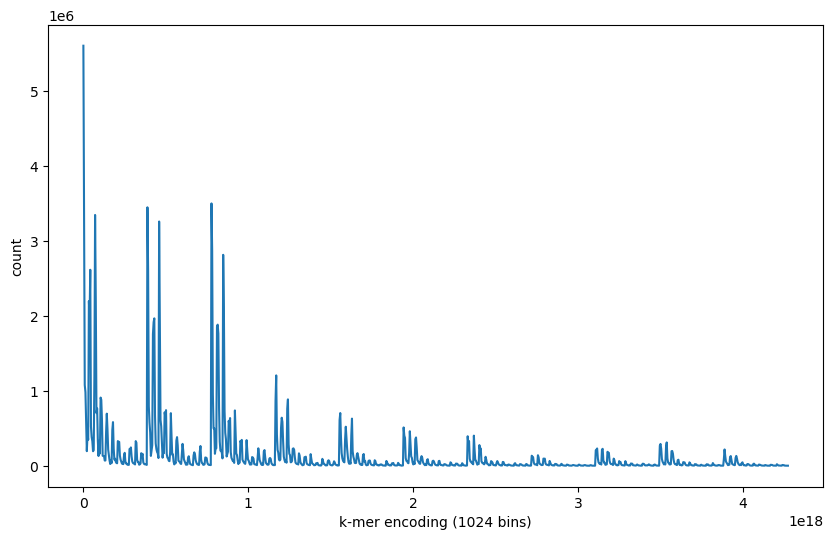

In [5]:
x = table.iloc[:,0]

plt.figure(figsize=(10,6))

# for column in table.columns[2:]:
#     plt.plot(x, table[column], label=column)

plt.plot(x, table["total"])
plt.xlabel("k-mer encoding (1024 bins)")
plt.ylabel("count")

# plt.legend()
plt.show()

In [25]:
base11_counts_zymo = pd.read_csv("C:\\Users\\nk035\\Documents\\diamer2\\statistics\\base11_counts_zymo.txt", sep=": ", header=None, names=["number", "count"])
# _2 = base11_counts_zymo["count"][1]
# base11_counts_zymo["count"][1] = base11_counts_zymo["count"][2]
# base11_counts_zymo["count"][2] = _2
# _7 = base11_counts_zymo["count"][9]
# base11_counts_zymo["count"][9] = base11_counts_zymo["count"][7]
# base11_counts_zymo["count"][7] = _7

zymno_mean = sum([i * base11_counts_zymo["count"][i] for i in range(len(base11_counts_zymo))]) / sum(base11_counts_zymo["count"])
base11_counts_zymo

C:\Users\nk035\AppData\Local\Temp\ipykernel_14568\175288690.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  base11_counts_zymo = pd.read_csv("C:\\Users\\nk035\\Documents\\diamer2\\statistics\\base11_counts_zymo.txt", sep=": ", header=None, names=["number", "count"])


,number,count
0,0,2920776439
1,1,1949437811
2,2,1830637054
3,3,514142039
4,4,513910784
5,5,450586530
6,6,249058792
7,7,275900774
8,8,262467223
9,9,150546931


In [26]:
base11_counts_nr100 = pd.read_csv("C:\\Users\\nk035\\Documents\\diamer2\\statistics\\base11_counts_nr100.txt", sep=": ", header=None, names=["number", "count"])

# _2 = base11_counts_nr100["count"][1]
# base11_counts_nr100["count"][1] = base11_counts_nr100["count"][2]
# base11_counts_nr100["count"][2] = _2
# _7 = base11_counts_nr100["count"][9]
# base11_counts_nr100["count"][9] = base11_counts_nr100["count"][7]
# base11_counts_nr100["count"][7] = _7

nr100_mean = sum([i * base11_counts_nr100["count"][i] for i in range(len(base11_counts_nr100))]) / sum(base11_counts_nr100["count"])
base11_counts_nr100

C:\Users\nk035\AppData\Local\Temp\ipykernel_14568\516717748.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  base11_counts_nr100 = pd.read_csv("C:\\Users\\nk035\\Documents\\diamer2\\statistics\\base11_counts_nr100.txt", sep=": ", header=None, names=["number", "count"])


,number,count
0,0,930399377
1,1,672806877
2,2,694816412
3,3,229603860
4,4,150393486
5,5,120829094
6,6,93554083
7,7,39872716
8,8,66460621
9,9,70456903


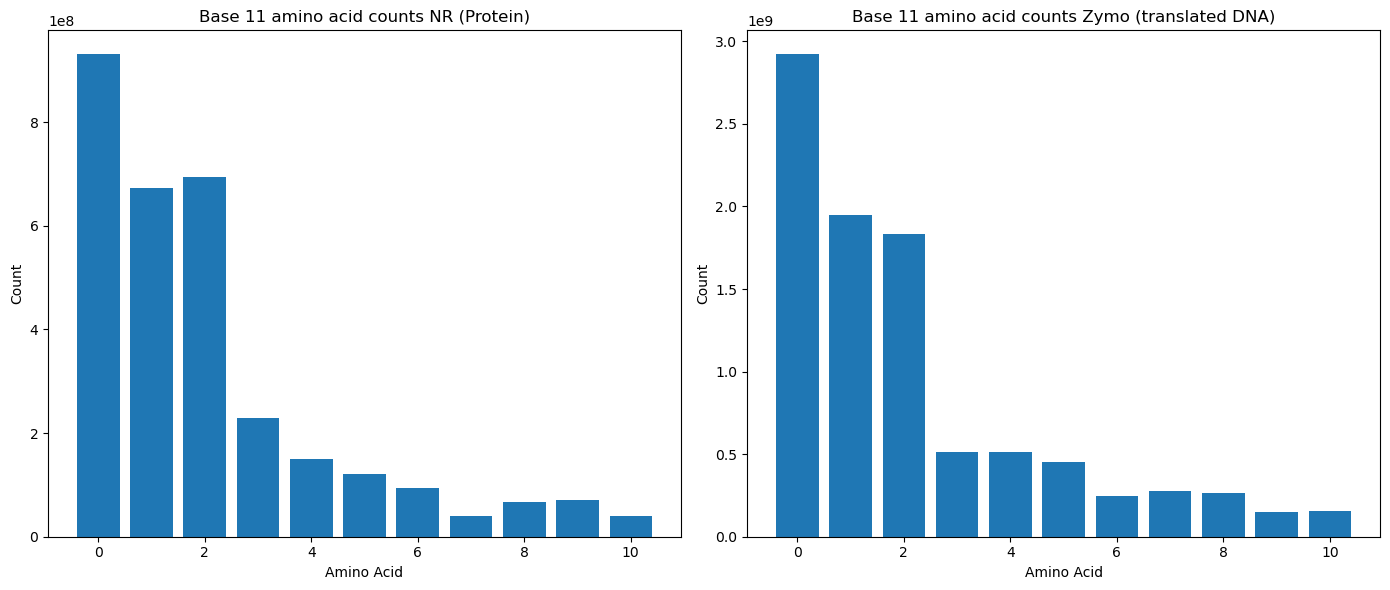

In [33]:
fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(14, 6))

# Plot the first bar plot
ax1.bar(base11_counts_zymo["number"], base11_counts_zymo["count"])
#ax1.axvline(zymno_mean, color='r', linestyle='dashed', linewidth=1)
ax1.set_xlabel("Amino Acid")
ax1.set_ylabel("Count")
ax1.set_title("Base 11 amino acid counts Zymo (translated DNA)")

# Plot the second bar plot
ax2.bar(base11_counts_nr100["number"], base11_counts_nr100["count"])
#ax2.axvline(nr100_mean, color='r', linestyle='dashed', linewidth=1)
ax2.set_xlabel("Amino Acid")
ax2.set_ylabel("Count")
ax2.set_title("Base 11 amino acid counts NR (Protein)")

# Display the figure
plt.tight_layout()
plt.show()

In [86]:
rows = []

with open("F:\\Studium\\Master\\semester5\\thesis\\data\\NCBI\\kmer_occurrences_longspaced.txt") as f:
    for line in f:
        values = line.split("\t")
        entries = {int(key): int(value) for key, value in [entry.split(":") for entry in values[2:]]}
        entries["bucket"] = values[0].split(" ")[1]
        entries["average"] = float(values[1])
        rows.append(entries)

# sort the columns
occ_ls = pd.DataFrame(rows)
occ_ls = occ_ls.reindex(["bucket", "average"] + sorted(occ_ls.columns.drop(["bucket", "average"])), axis=1)

# calculate row sums and convert to percentages
row_sums = occ_ls.iloc[:, 2:].sum(axis=1)
occ_ls.iloc[:, 2:] = occ_ls.iloc[:, 2:].div(row_sums, axis=0) * 100
occ_ls['sum'] = row_sums
occ_ls = occ_ls.reindex(["bucket", "average", "sum"] + sorted(occ_ls.columns.drop(["bucket", "average", "sum"])), axis=1)

occ_ls

C:\Users\nk035\AppData\Local\Temp\ipykernel_11672\3722694197.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  occ_ls['sum'] = row_sums


,bucket,average,sum,1,2,3,4,5,6,7,...,3509314,3510650,3511356,3513133,3517585,3519056,3556295,9853585,10893928,396220181
0,0,11.935786,56620203.0,61.562139,15.388578,6.603268,3.742071,2.378944,1.656455,1.212161,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000002
1,1,4.984880,56615643.0,61.555374,15.387495,6.600234,3.748264,2.382446,1.660997,1.211195,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000002,NaN,NaN
2,2,5.228943,56623402.0,61.556595,15.387311,6.597737,3.744598,2.381794,1.659386,1.212666,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000002,NaN
3,3,5.271318,56620125.0,61.549993,15.391792,6.598290,3.745728,2.381000,1.659060,1.213959,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,5.042588,56628592.0,61.556026,15.389595,6.600212,3.744363,2.380909,1.657331,1.214358,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,99,5.033649,56632988.0,61.541427,15.395207,6.602560,3.749287,2.379790,1.660409,1.212076,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100,100,5.195021,56608549.0,61.552685,15.382035,6.606550,3.748047,2.381958,1.660788,1.212421,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101,101,5.140609,56617011.0,61.553191,15.393026,6.598024,3.748163,2.376812,1.658018,1.212738,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102,102,4.811862,56610754.0,61.546455,15.388786,6.604492,3.747781,2.382164,1.658388,1.210169,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


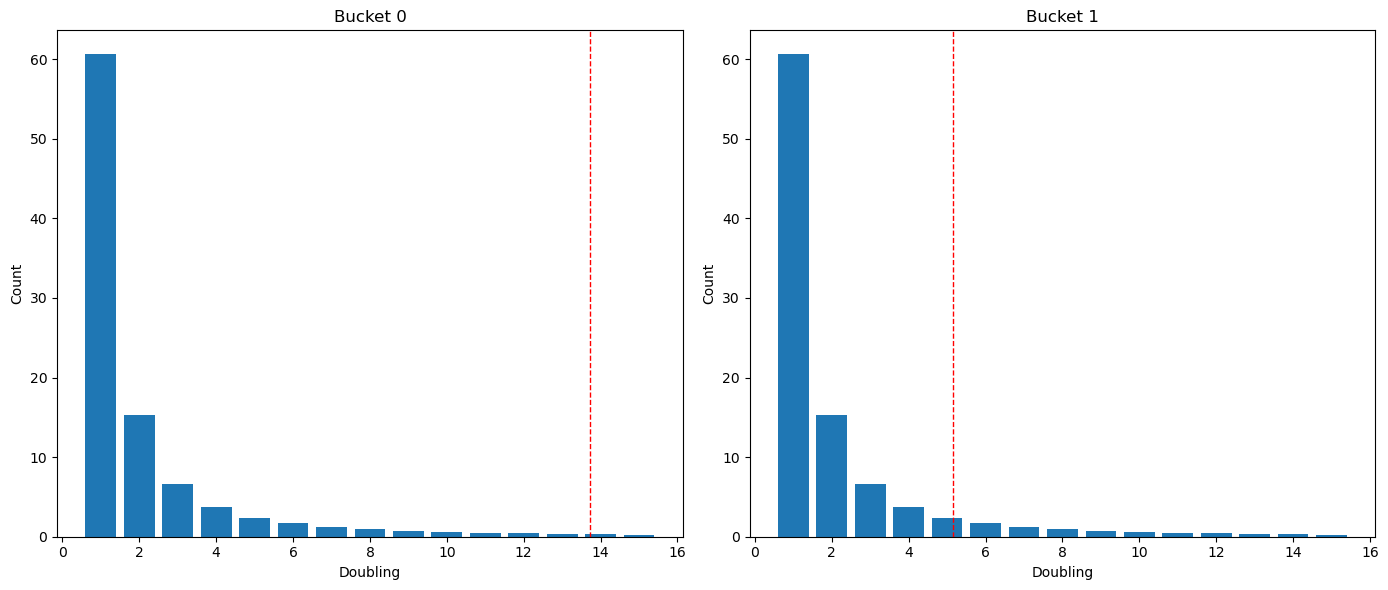

In [76]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot the first bar plot
ax1.bar(occ_ls.columns.drop(["bucket", "average", "sum"])[:15], occ_ls.iloc[0].drop(["bucket", "average", "sum"])[:15])
ax1.axvline(occ_ls.iloc[0]["average"], color='r', linestyle='dashed', linewidth=1)
ax1.set_xlabel("Doubling")
ax1.set_ylabel("Count")
ax1.set_title("Bucket 0")

# Plot the second bar plot
ax2.bar(occ_ls.columns.drop(["bucket", "average", "sum"])[:15], occ_ls.iloc[1].drop(["bucket", "average", "sum"])[:15])
ax2.axvline(occ_ls.iloc[1]["average"], color='r', linestyle='dashed', linewidth=1)
ax2.set_xlabel("Doubling")
ax2.set_ylabel("Count")
ax2.set_title("Bucket 1")

# Display the figure
plt.tight_layout()
plt.show()

In [87]:
rows = []

with open("F:\\Studium\\Master\\semester5\\thesis\\data\\NCBI\\kmer_occurrences_no_mask.txt") as f:
    for line in f:
        values = line.split("\t")
        entries = {int(key): int(value) for key, value in [entry.split(":") for entry in values[2:]]}
        entries["bucket"] = values[0].split(" ")[1]
        entries["average"] = float(values[1])
        rows.append(entries)

# sort the columns
occ = pd.DataFrame(rows)
occ = occ.reindex(["bucket", "average"] + sorted(occ.columns.drop(["bucket", "average"])), axis=1)

# calculate row sums and convert to percentages
row_sums = occ_ls.iloc[:, 2:].sum(axis=1)
occ.iloc[:, 2:] = occ.iloc[:, 2:].div(row_sums, axis=0) * 100
occ['sum'] = row_sums
occ = occ.reindex(["bucket", "average", "sum"] + sorted(occ.columns.drop(["bucket", "average", "sum"])), axis=1)

occ

C:\Users\nk035\AppData\Local\Temp\ipykernel_11672\3912453283.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  occ['sum'] = row_sums


,bucket,average,sum,1,2,3,4,5,6,7,...,3489842,3489927,3494317,3498621,3504883,3507749,3511327,3667978,3773432,472874882
0,0,13.715886,56620303.0,60.586347,15.260210,6.574280,3.743823,2.384947,1.663711,1.222277,...,NaN,0.000002,NaN,NaN,NaN,0.000002,NaN,NaN,NaN,0.000002
1,1,5.141871,56615743.0,60.597740,15.268243,6.570655,3.746320,2.384570,1.668179,1.220678,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000002,NaN,NaN
2,2,5.254500,56623502.0,60.586426,15.260402,6.575277,3.742232,2.384513,1.666845,1.220643,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000002,NaN
3,3,5.557075,56620225.0,60.582329,15.264152,6.571535,3.743918,2.382550,1.663125,1.222090,...,NaN,NaN,NaN,0.000002,NaN,NaN,NaN,NaN,NaN,NaN
4,4,5.299953,56628692.0,60.573410,15.257903,6.576908,3.748411,2.380828,1.666551,1.221245,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,5.284738,56624966.0,60.582509,15.261683,6.566280,3.740080,2.383650,1.669446,1.217555,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000002,NaN,NaN,NaN
6,6,5.341595,56634795.0,60.572800,15.256893,6.572534,3.747532,2.387103,1.666603,1.218242,...,0.000002,NaN,0.000002,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7,5.585336,56611893.0,60.618642,15.261599,6.564859,3.744423,2.385071,1.665510,1.218984,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8,5.220836,56615005.0,60.589932,15.259506,6.573944,3.750649,2.385059,1.668249,1.220337,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9,5.516894,56625094.0,60.586047,15.266288,6.581617,3.746336,2.381299,1.666572,1.219087,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


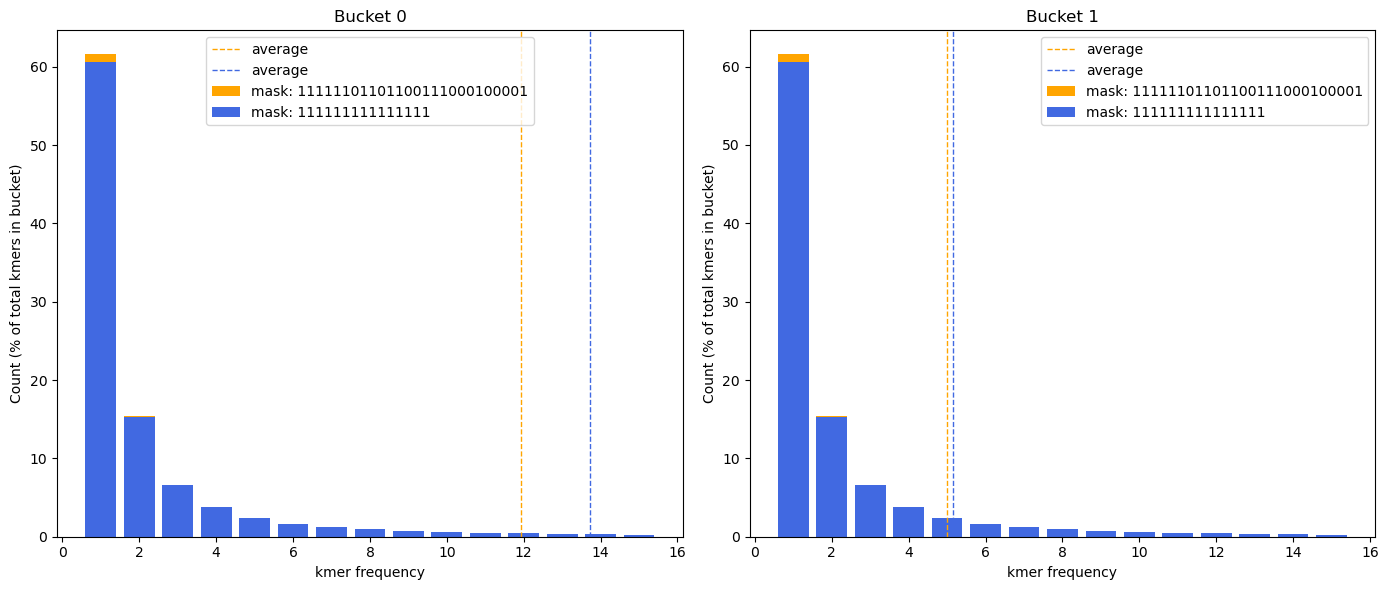

In [89]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot the first bar plot
ax1.bar(occ_ls.columns.drop(["bucket", "average", "sum"])[:15], occ_ls.iloc[0].drop(["bucket", "average", "sum"])[:15], label='mask: 11111101101100111000100001', color="orange")
ax1.bar(occ.columns.drop(["bucket", "average", "sum"])[:15], occ.iloc[0].drop(["bucket", "average", "sum"])[:15], label="mask: 111111111111111", color="royalblue")
ax1.axvline(occ_ls.iloc[0]["average"], color='orange', linestyle='dashed', linewidth=1, label="average")
ax1.axvline(occ.iloc[0]["average"], color='royalblue', linestyle='dashed', linewidth=1, label="average")
ax1.set_xlabel("kmer frequency")
ax1.set_ylabel("Count (% of total kmers in bucket)")
ax1.set_title("Bucket 0")
ax1.legend()

# Plot the second bar plot
ax2.bar(occ_ls.columns.drop(["bucket", "average", "sum"])[:15], occ_ls.iloc[1].drop(["bucket", "average", "sum"])[:15], label='mask: 11111101101100111000100001', color="orange")
ax2.bar(occ.columns.drop(["bucket", "average", "sum"])[:15], occ.iloc[1].drop(["bucket", "average", "sum"])[:15], label="mask: 111111111111111", color="royalblue")
ax2.axvline(occ_ls.iloc[1]["average"], color='orange', linestyle='dashed', linewidth=1, label="average")
ax2.axvline(occ.iloc[1]["average"], color='royalblue', linestyle='dashed', linewidth=1, label="average")
ax2.set_xlabel("kmer frequency")
ax2.set_ylabel("Count (% of total kmers in bucket)")
ax2.set_title("Bucket 1")
ax2.legend()

# Display the figure
plt.tight_layout()
plt.show()

In [3]:
nd_ass = pd.read_csv("C:\\Users\\noel\\Downloads\\per_taxon_assignments.tsv", header=0, sep="\t")
#nd_ass
nd_ass[nd_ass['Taxon'].str.startswith('(species)')].sort_values(["OVO (ratio: 0.800000)"], ascending=False)
#nd_ass["name"] = [name.split("(")[-1][:-1] for name in  nd_ass["name"]]
#nd_ass.sort_values(["OVO (ratio: 0.800000)"], ascending=False)
#to_csv("F:\\Studium\\Master\\semester5\\thesis\\data\\test_dataset\\test_results\\whole_nr\\custom_values_ids.tsv", sep="\t", header=True, index=False)

,Taxon,kmer count,OVO (ratio: 0.200000),OVO (ratio: 0.800000)
1110,(species) Limosilactobacillus fermentum (1613),1708954,390,21849
6511,(species) Salmonella enterica (28901),6180492,41,4246
198,(species) Pseudomonas aeruginosa (287),7967322,13,3662
2742,(species) Saccharomyces cerevisiae (4932),412867,13,3100
869,(species) Staphylococcus aureus (1280),2641332,24,2873
...,...,...,...,...
131147,(species) Pregotovirus myuchelyis (3241180),76,0,0
131148,(species) Seadornavirus kadipiroense (3241299),210,0,0
131149,(species) Sectovirus xinzhouense (3241301),14,0,0
131150,(species) Seadornavirus liaoningense (3241300),158,0,0


In [3]:
print("(species) test (1023)".split("(")[-1][:-1])

1023
